# Распознавание рукописных цифр с помощью сверточной нейронной сети LeNet

**Переписать ноутбук по распознаванию рукописных цифр своими руками, восстановив следующие операции:**

1. Импорт библиотек.
2. Загрузка базы mnist.
3. Нормирование и преобразование `x_train` и `y_train`.
4. Создание сверточной нейронной сети.
5. Обучение сверточной нейронной сети.
Можно смотреть в ноутбук с занятия, но код писать самостоятельно.

In [1]:
from pathlib import Path
import re
from typing import List

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Activation,
    BatchNormalization,
    Conv2D,
    Dense,  
    Dropout, 
    Flatten,
    MaxPooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

from PIL import Image

from matplotlib import pyplot as plt
%matplotlib inline

Установить уровень диагностических сообщений для TensorFlow.

In [2]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Отобразить список доступных устройств.

In [3]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Определить каталог для загрузки изображений.

In [4]:
IMG_PATH = Path.cwd().parent.parent / 'data' / 'images' / '01-mnist'

Задать количество эпох для обучения.

In [5]:
EPOCHS = 25

## Подготовка данных

Загрузка данных MNIST:

In [6]:
(x_org, y_org), (x_test_org, y_test_org) = mnist.load_data()

In [7]:
print(f"{x_org.shape}, {x_test_org.shape}")

(60000, 28, 28), (10000, 28, 28)


Отобразить примеры цифр из набора

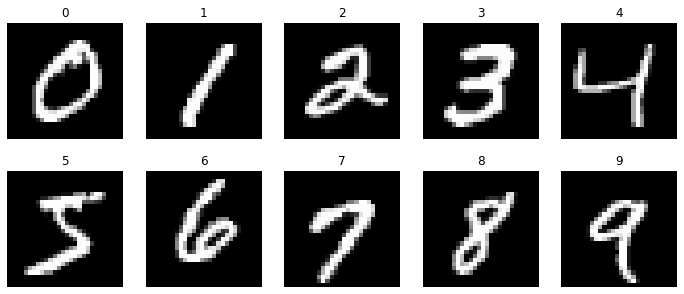

In [8]:
digits = np.unique(y_org)

_, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

for digit, ax in zip(digits, axes):
    ax.imshow(
        Image.fromarray(x_org[y_org == digit][0]).convert('RGB')
    )

    ax.set_title(str(digit))
    ax.set_axis_off()

plt.show();

Изменить формат входных изображений:

In [9]:
x = x_org[:, :, :, np.newaxis] / 255
x_test = x_test_org[:, :, :, np.newaxis] / 255

In [10]:
print(f"{x.shape}, {x_test.shape}")

(60000, 28, 28, 1), (10000, 28, 28, 1)


Преобразовать ответы в унитарный код (one-hot)

In [11]:
y = utils.to_categorical(y_org, 10)
y_test = utils.to_categorical(y_test_org, 10)

In [12]:
print(f"{y.shape}, {y_test.shape}")

(60000, 10), (10000, 10)


Выделить обучающую и валидационную выборки.

In [13]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)

In [14]:
print(f"{x_train.shape}, {x_val.shape}")

(48000, 28, 28, 1), (12000, 28, 28, 1)


## Создание нейронной сети

Вспомогательный класс для создания нейронной сети заданной архитектуры.

In [15]:
class LeNet:

    @staticmethod
    def build(dropout=True, batch_normalization=True) -> Sequential:
        model = Sequential()

        if batch_normalization:
            model.add(BatchNormalization(input_shape=(28, 28, 1)))

        model.add(
            Conv2D(
                20,
                kernel_size=5,
                padding='same',
                input_shape=(28, 28, 1)
            )
        )
        model.add(Activation('relu'))
        model.add(
            MaxPooling2D(
                pool_size=(2, 2),
                strides=(2, 2)
            )
        )

        model.add(
            Conv2D(
                50,
                kernel_size=5,
                padding='same'
            )
        )
        model.add(Activation('relu'))
        model.add(
            MaxPooling2D(
                pool_size=(2, 2),
                strides=(2, 2)
            )
        )

        if dropout:
            model.add(Dropout(0.25))
        model.add(Flatten())

        model.add(Dense(500))
        model.add(Activation('relu'))
        if dropout:
            model.add(Dropout(0.25))

        model.add(Dense(10))
        model.add(Activation('softmax'))

        model.compile(
            loss='categorical_crossentropy',
            optimizer=Adam(),
            metrics=['accuracy']
        )

        return model

Создать нейронную сеть LeNet:

In [16]:
net = LeNet.build()

print(net.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 20)        520       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 20)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 50)        25050     
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 50)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 50)          0

## Обучение нейронной сети

Обучить нейронную сеть.

In [17]:
history = net.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    verbose=1
)

Epoch 1/25
375/375 [==============================] - 2s 5ms/step - loss: 0.1689 - accuracy: 0.9477 - val_loss: 0.0519 - val_accuracy: 0.9851
Epoch 2/25
375/375 [==============================] - 2s 5ms/step - loss: 0.0547 - accuracy: 0.9826 - val_loss: 0.0391 - val_accuracy: 0.9881
Epoch 3/25
375/375 [==============================] - 2s 5ms/step - loss: 0.0401 - accuracy: 0.9871 - val_loss: 0.0347 - val_accuracy: 0.9896
Epoch 4/25
375/375 [==============================] - 2s 5ms/step - loss: 0.0299 - accuracy: 0.9902 - val_loss: 0.0354 - val_accuracy: 0.9898
Epoch 5/25
375/375 [==============================] - 2s 5ms/step - loss: 0.0244 - accuracy: 0.9921 - val_loss: 0.0303 - val_accuracy: 0.9908
Epoch 6/25
375/375 [==============================] - 2s 5ms/step - loss: 0.0218 - accuracy: 0.9930 - val_loss: 0.0278 - val_accuracy: 0.9924
Epoch 7/25
375/375 [==============================] - 2s 5ms/step - loss: 0.0179 - accuracy: 0.9940 - val_loss: 0.0252 - val_accuracy: 0.9930
Epoch 

Отобразить процесс изменения loss и accuracy в процессе обучения.

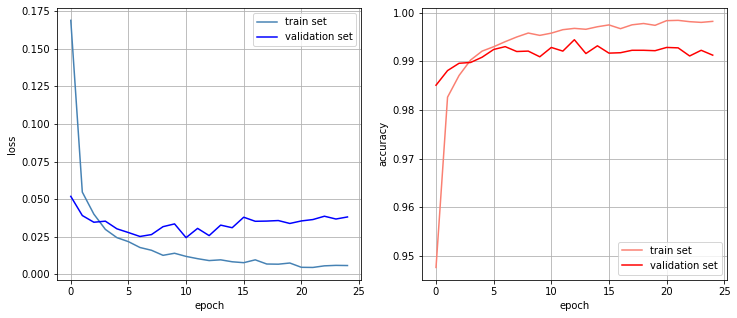

In [18]:
_, axes = plt.subplots(1, 2, figsize=(12, 5))

axes = axes.flatten()

axes[0].plot(
    history.epoch,
    history.history['loss'],
    color='steelblue',
    label='train set'
)
axes[0].plot(
    history.epoch,
    history.history['val_loss'],
    color='blue',
    label='validation set'
)
axes[0].set_ylabel('loss')
axes[0].set_xlabel('epoch')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(
    history.epoch,
    history.history['accuracy'],
    color='salmon',
    label='train set'
)
axes[1].plot(
    history.epoch,
    history.history['val_accuracy'],
    color='red',
    label='validation set'
)
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend()
axes[1].grid(True)

plt.show();

Сохранить веса нейронной сети.

In [19]:
path = Path.home() / 'aiu-03-mnist-ultra-light-model'

net.save(path);

## Тестирование работы нейронной сети

Получение loss и accuracy для тестовой выборки:

In [20]:
score = net.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0293 - accuracy: 0.9916


In [21]:
print(f"Test loss: {score[0]:.5f}\nTest accuracy: {score[1]:.5f}")

Test loss: 0.02928
Test accuracy: 0.99160


Загрузить набор цифр, написанных карандашом.

In [22]:
images_org = []
for path in IMG_PATH.iterdir():
    match = re.match(r'^.*(\d)l.png$', str(path))
    if match:
        images_org.append(
            (
                int(match[1]),
                image.load_img(path, target_size=(28, 28), color_mode='grayscale'),
            )
        )

images_org.sort(key=lambda item: item[0])

Отобразить загруженные изображения.

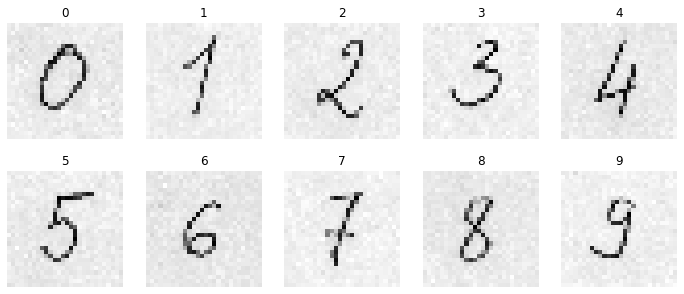

In [23]:
_, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

for idx, (image_org, ax) in enumerate(zip(images_org, axes)):
    ax.imshow(image_org[1], cmap='gray')

    ax.set_title(str(idx))
    ax.set_axis_off()

plt.show();

Выполнить инверсию цветов и нормирование. Индекс элемента в списке `digits` соответствует распознаваемой цифре.

In [24]:
digits = []
for _, img in images_org:
    digit = image.img_to_array(img)
    digits.append(np.clip(1. - digit / digit.max(), 0., 1.))

Отобразить результаты инверсии цветов и нормирования.

In [25]:
def plot_digits(digits: List[np.ndarray]):
    _, axes = plt.subplots(2, 5, figsize=(12, 5))
    axes = axes.flatten()

    for idx, (digit, ax) in enumerate(zip(digits, axes)):
        ax.imshow(digit, cmap='gray')

        ax.set_title(str(idx))
        ax.set_axis_off()

    plt.show()

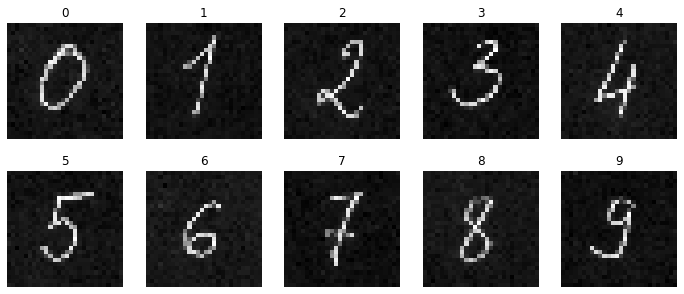

In [26]:
plot_digits(digits);

Удалить шум на фоне цифр.

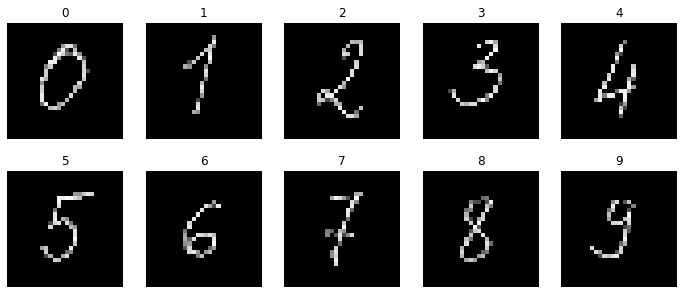

In [27]:
digits = [np.where(digit < 0.15, 0., digit) for digit in digits]

plot_digits(digits);

Выполнить линейное контрастирование.

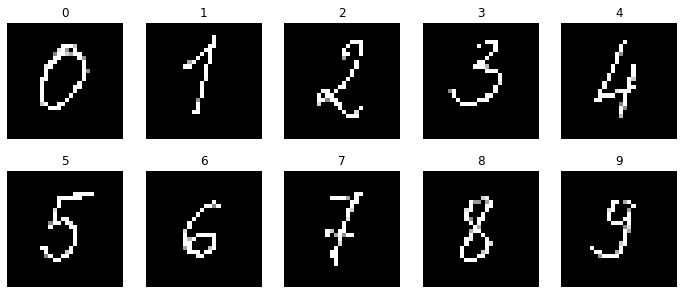

In [28]:
digits = [np.clip(0.5 * digit / 0.15, 0., 1.) for digit in digits]

plot_digits(digits);

Подготовить данные для распознавания.

In [29]:
data = np.vstack(digit[np.newaxis, :, :] for digit in digits)

In [30]:
data.shape

(10, 28, 28, 1)

Выполнить распознавание данных нейронной сетью.

In [31]:
predicted = np.argmax(net.predict(data, verbose=1), axis=0)

1/1 [==============================] - 0s 1ms/step


Отобразить результаты распознавания. Так как индекс в списке соответствует распознаваемой цифре, то будем сравнивать индексы элементов с их значениями.

In [32]:
count = 0

for idx, value in enumerate(predicted):
    if idx == value:
        fmt = "Требуется: {}, предсказано: {}"
        count += 1
    else:
        fmt = "Требуется: {}, предсказано: {}, несовпадение!"

    print(fmt.format(idx, value))

print(f"\nAccuracy: {count / len(predicted)}")

Требуется: 0, предсказано: 0
Требуется: 1, предсказано: 1
Требуется: 2, предсказано: 2
Требуется: 3, предсказано: 3
Требуется: 4, предсказано: 4
Требуется: 5, предсказано: 5
Требуется: 6, предсказано: 6
Требуется: 7, предсказано: 7
Требуется: 8, предсказано: 8
Требуется: 9, предсказано: 9

Accuracy: 1.0
